In [1]:
import gym
import random
import numpy as np
import matplotlib.pyplot as plt

## Fonctions

In [2]:
def e_greedy(state, epsilon, q, env):
    exp_exp_tradeoff = random.uniform(0, 1)
    if exp_exp_tradeoff > epsilon:
        return np.argmax(q[state, :])
    return env.action_space.sample()


def maj_q(q_local, state, action, new_state, reward, learning_rate, gamma):
    q_init = q_local[state, action]
    max_state = np.max(q_local[new_state, :])
    q_local[state, action] = (1 - learning_rate) * q_init + learning_rate * (reward + gamma * max_state)
    return q_local

def is_fractile(episode_actuel, episode_total):
    return episode_actuel % (episode_total/50) == 0

def show_q(local_q):
    env = gym.make("Taxi-v3", render_mode="human")
    state = env.reset()[0]
    for step in range(200):
        env.render()
        action = np.argmax(local_q[state, :])
        (new_state, reward, done, info, _) = env.step(action)
        if done:
            break
        state = new_state
    env.close()

# Renforcement

In [3]:
def train(epsilon = 1.0, max_steps = 200, alpha = 0.7, gamma = 0.8, max_epsilon = 1.0, min_epsilon = 0.05, decay_rate = 0.01, total_episodes = 750, total_test_episodes = 1):
    title = "Epsilon: {}, learning_rate: {}, gamma: {} ".format(epsilon, alpha, gamma)
    env = gym.make("Taxi-v3", render_mode="ansi")
    env.reset()
    action_size = env.action_space.n
    state_size = env.observation_space.n
    q = np.zeros((state_size, action_size))
    rewards = []
    for i in range(0, 50):
        print('=', end= '')
    print()
    for episode in range(total_episodes):
        if is_fractile(episode, total_episodes):
            print("\b=>", end='')
        (state) = env.reset()[0]
        count = 0
        for step in range(max_steps):
            action = e_greedy(state, epsilon, q, env)
            (new_state, reward, done, info, _) = env.step(action)
            q = maj_q(q, state, action, new_state, reward, alpha, gamma)
            state = new_state
            count += reward
            if done:
                rewards.append(count)
                break
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)
    plt.title(title)
    plt.plot(rewards, color="red")
    plt.show()
    env = gym.make("Taxi-v3", render_mode="ansi")
    env.reset()

    for episode in range(total_test_episodes):
        state = env.reset()[0]
        total_rewards = 0
        for step in range(max_steps):
            env.render()
            action = np.argmax(q[state, :])
            (new_state, reward, done, info, _) = env.step(action)
            total_rewards += reward
            if done:
                break
            state = new_state
    env.close()
    return q

==================================================>

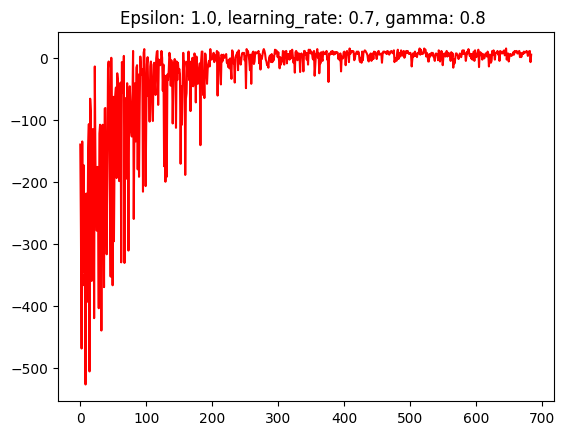

In [4]:
q = train()
show_q(q)

# Etudes des hyperparamètres
## Gamma
Cet hyperparamètre définit l'importance des futurs rewards sur le choix de la prochaine action. Si gamma est proche de 0, l'agent ne considerera que les récompenses immédiates. A l'inverse, si gamma est proche de 1, il sera capable de faire abstraction de la récompense à venir si les récompenses futures sont plus intéressantes.

==================================================>

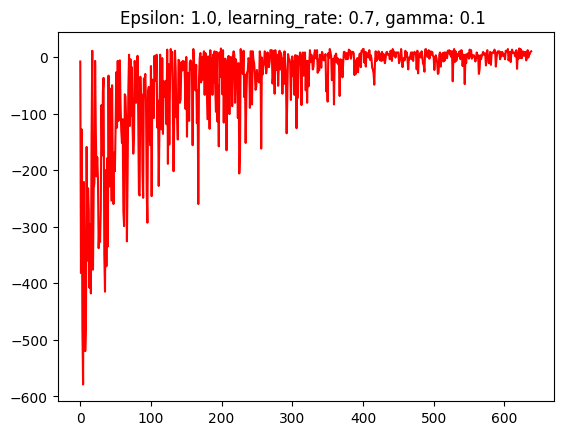

==================================================>

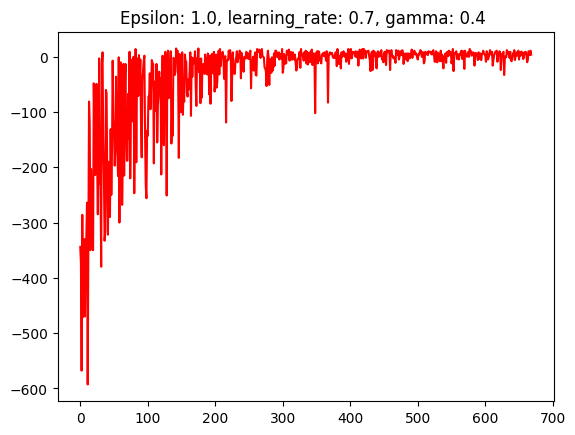

==================================================>

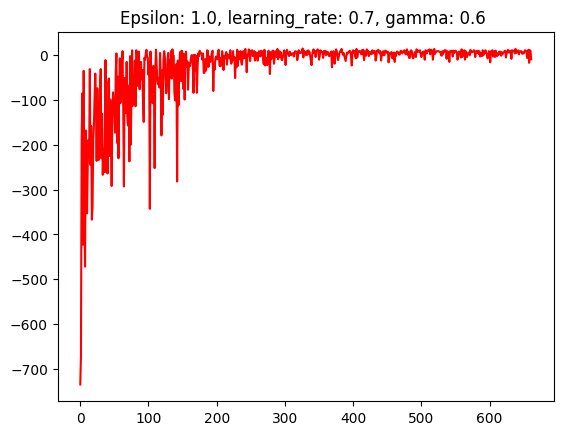

==================================================>

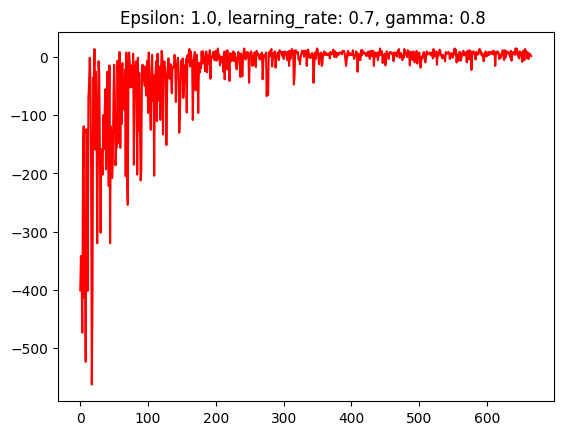

==================================================>

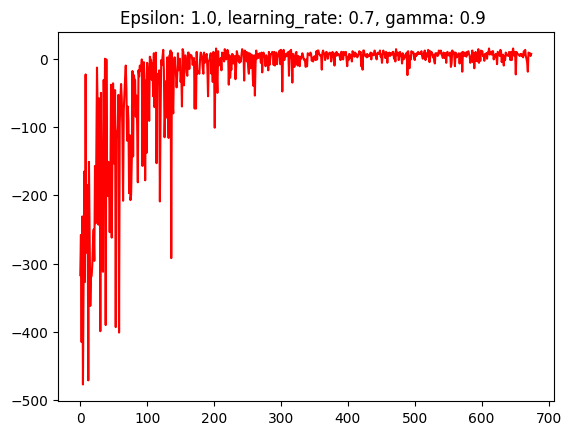

==================================================>

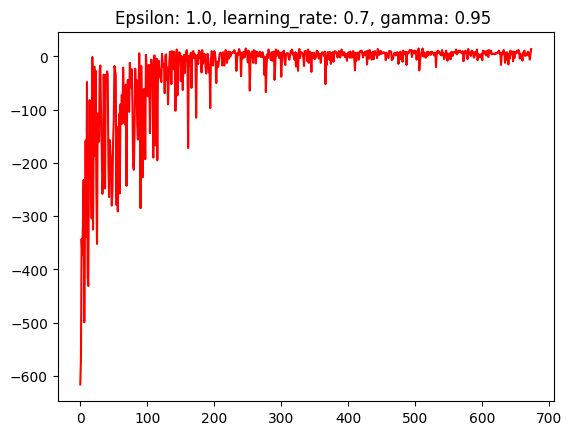

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.42091187,  -4.13766606,  -4.84852569,   1.52283684,
          5.20997639,  -7.5594319 ],
       [ -3.74193768,   5.48019211,  -1.01041857,   5.40410613,
         10.9512375 , -12.72516191],
       ...,
       [ -3.50016613,  -2.98742406,  -3.29781542,   3.4061179 ,
        -10.52861019,  -9.5655    ],
       [ -4.43087357,  -4.24770818,  -4.36475769,  -4.392051  ,
         -9.5655    ,  -9.5655    ],
       [ 15.64638999,  12.82135435,  14.651     ,  18.        ,
          7.05553137,   7.09078473]])

In [5]:
train(gamma=0.1)
train(gamma=0.4)
train(gamma=0.6)
train(gamma=0.8)
train(gamma=0.9)
train(gamma=0.95)

On observe sur les résultats ci-dessus que gamma influence la vitesse de stabilisation des résultats. En effet, plus gamma est élevé, plus l'agent apprend rapidement de son environnement. Il faut un peu moins de 400 itérations pour que le résultat se stabilise avec gamma = 0.6 alors que, pour gamma = 0.95, il faut environ 250 itérations.

## Alpha
Cet hyperparamètre permet de controler la vitesse d'apprentissage du programme. Alpha permet de determiner le poids que l'on donne aux expériences précédentes lors de la mise à jour des q-values.

==================================================>

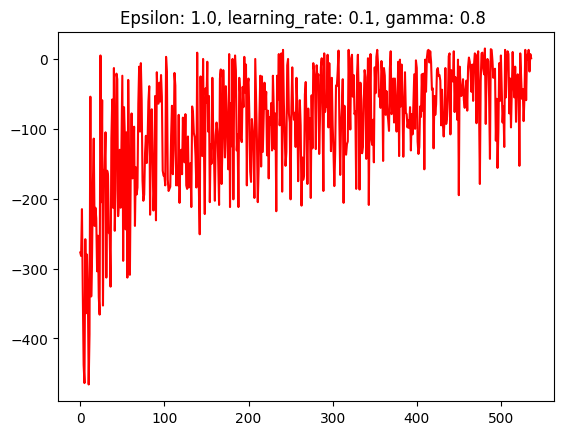

==================================================>

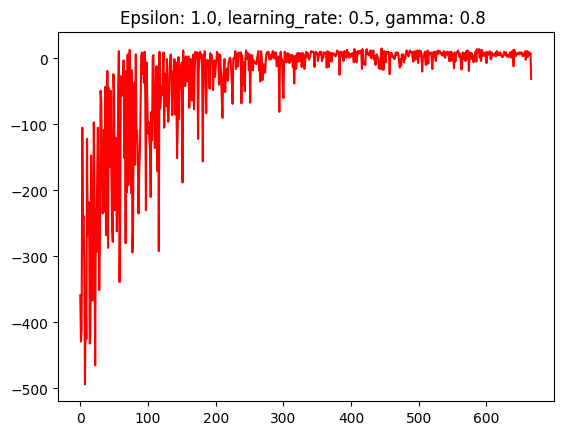

==================================================>

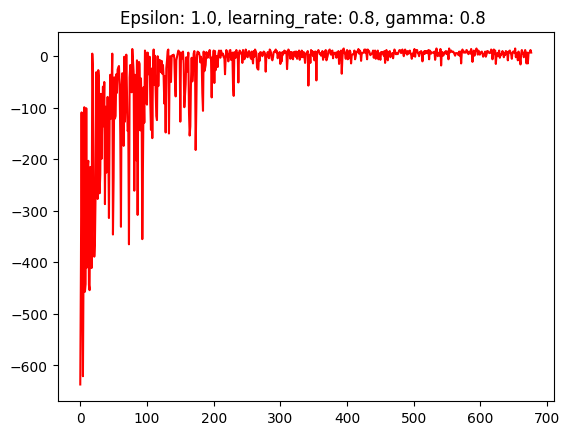

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [ -2.91354906,  -3.76534664,  -4.01282581,  -3.81035652,
         -1.6445568 , -12.38250928],
       [ -0.51150277,  -3.25730729,  -0.99260556,   1.55199508,
          3.192     ,  -8.42356511],
       ...,
       [ -2.5106432 ,   0.53136501,  -2.60547584,  -2.77262985,
        -10.432     , -11.53882112],
       [ -3.42018101,  -2.22177515,  -3.46026776,  -3.44161478,
        -12.42702423, -11.79624619],
       [  0.        ,   0.        ,   8.76628992,  14.99957862,
          0.        ,   1.56628992]])

In [6]:
train(alpha=0.1)
train(alpha=0.5)
train(alpha=0.8)

On remarque que plus alpha est élevée, plus l'agent apprend rapidement des étapes précédentes.

## Epsilon
Epsilon est l'hyperparamètre qui permet de déterminer l'action sélectionnée par l'agent. Si epsilon est grand, il y a plus de chance que l'agent choisisse une action de manière aléatoire. Si epsilon est petit, l'agent choisira la meilleure action par rapport aux q-values qu'il a déjà obtenu.

Ici, nous allons étudier l'influence de la vitesse de décroissance de epsilon sur l'apprentissage de l'agent.

==================================================>

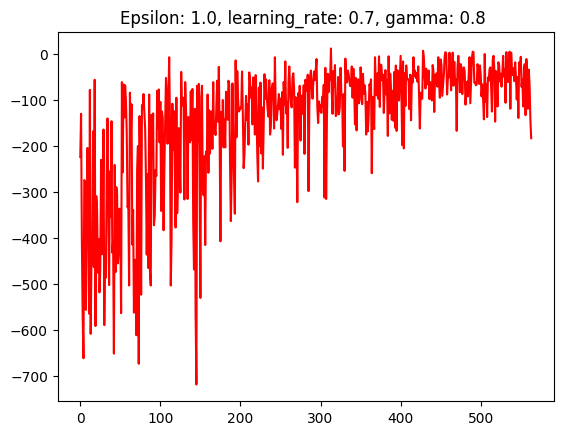

==================================================>

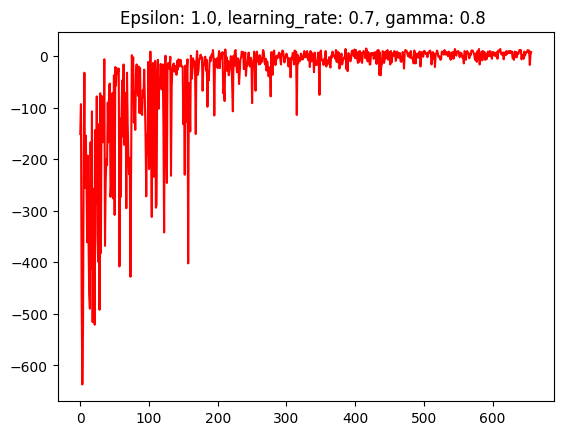

==================================================>

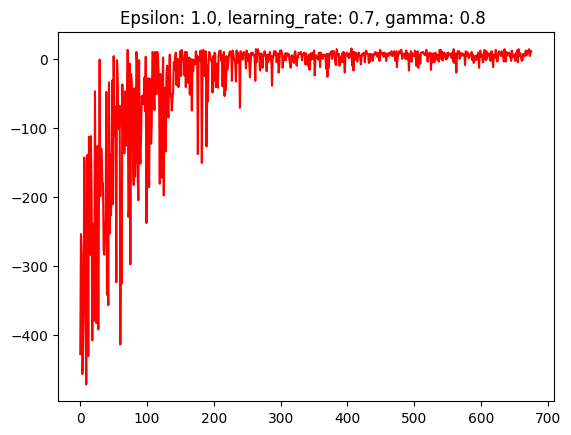

==================================================>

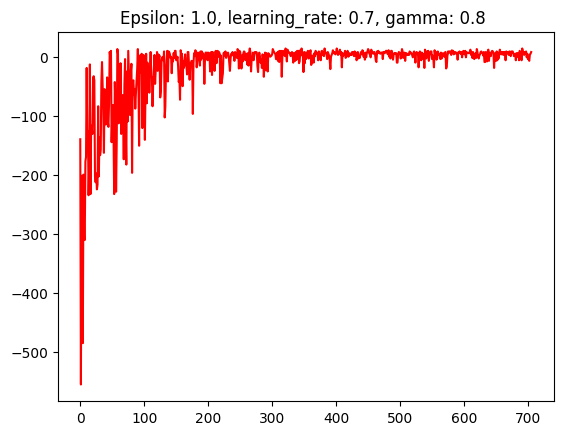

==================================================>

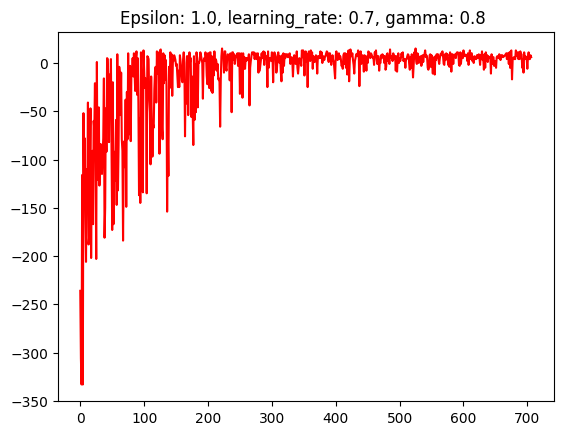

==================================================>

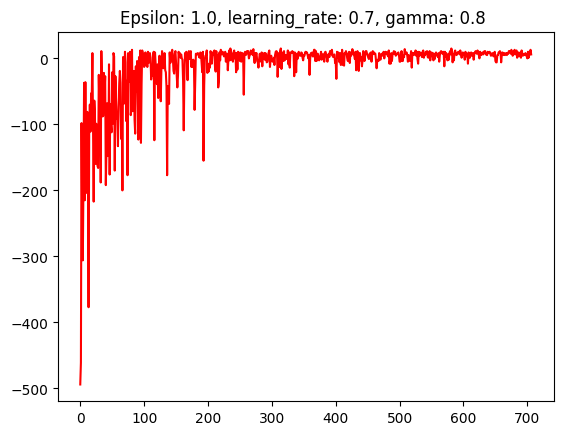

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-3.823597  , -3.71336291, -3.7215456 , -3.71336291, -1.6445568 ,
        -7.        ],
       [-2.85630301,  1.14583125, -2.85074191, -2.97716382,  3.192     ,
        -7.        ],
       ...,
       [-2.2649592 , -2.2812132 , -2.2649592 , -2.06514336, -7.        ,
        -9.492     ],
       [-3.57697521, -3.41185118, -3.50391036, -3.51470474, -9.492     ,
        -7.        ],
       [-1.302     , -0.91      , -1.302     , 12.579     , -7.        ,
        -5.2192    ]])

In [7]:
train(decay_rate=0.001)
train(decay_rate=0.005)
train(decay_rate=0.01)
train(decay_rate=0.05)
train(decay_rate=0.1)
train(decay_rate=0.5)

On observe que lorsque la vitesse de décroissante est très basse, l'agent a du mal à apprendre car, epsilon restant élevé, il va selectionner des actions aléatoirement, sans prendre compte de ce qu'il a déjà appris lors des itérations précédentes. Par contre, on remarque que si la vitesse de décroissance est trop élevée, l'agent n'obtient pas des résultats optimaux car il n'a pas eu le temps d'explorer les différentes options qui lui sont possibles.
On se rend compte qu'une vitesse de décroissance de 0.01 permet à l'agent d'avoir une phase d'exploration des différents états puis, une phase d'exploitation des résultats obtenus grace à cette exploration.

On remarque que si epsilon descend trop bas, en cas de problème dans Q, l'agent peux executer en boucle une action qui ne le change pas de position (ex : récupérer l'utilisateur). Si celui-ci est à 0.01, en cas de problème, il faudrait environ 100 actions pour espérer que le e-greedy en prenne une aléatoire qui q un impact sur sa position.

# Deep-Q Learning

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import gym
from kaggle_environments import make, evaluate
from gym import spaces

device = 'cpu'

class ConnectFourGym(gym.Env):
    def __init__(self, agent2="random"):
        ks_env = make("connectx", debug=True)
        self.env = ks_env.train([None, agent2])
        self.rows = ks_env.configuration.rows
        self.columns = ks_env.configuration.columns
        # Learn about spaces here: http://gym.openai.com/docs/#spaces
        self.action_space = spaces.Discrete(self.columns)
        self.observation_space = spaces.Box(low=0, high=2,
                                            shape=(1,self.rows,self.columns), dtype=int)
        # Tuple corresponding to the min and max possible rewards
        self.reward_range = (-10, 1)
        # StableBaselines throws error if these are not defined
        self.spec = None
        self.metadata = None
    def reset(self):
        self.obs = self.env.reset()
        return np.array(self.obs['board']).reshape(1,self.rows,self.columns)
    def change_reward(self, old_reward, done):
        if old_reward == 1: # The agent won the game
            return 1
        elif done: # The opponent won the game
            return -1
        else: # Reward 1/42
            return 1/(self.rows*self.columns)
    def step(self, action):
        # Check if agent's move is valid
        is_valid = (self.obs['board'][int(action)] == 0)
        if is_valid: # Play the move
            self.obs, old_reward, done, _ = self.env.step(int(action))
            reward = self.change_reward(old_reward, done)
        else: # End the game and penalize agent
            reward, done, _ = -10, True, {}
        return np.array(self.obs['board']).reshape(1,self.rows,self.columns), reward, done, _

env = ConnectFourGym(agent2="random")

import torch as th
import torch.nn as nn
from stable_baselines3 import PPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

class CustomCNN(BaseFeaturesExtractor):

    def __init__(self, observation_space: gym.spaces.Box, features_dim: int=128):
        super(CustomCNN, self).__init__(observation_space, features_dim)
        # CxHxW images (channels first)
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(),
        )
        self.cnn.to(device)

        # Compute shape by doing one forward pass
        with th.no_grad():
            n_flatten = self.cnn(
                th.as_tensor(observation_space.sample()[None]).float()
            ).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())
        self.linear.to(device)

    def forward(self, observations: th.Tensor) -> th.Tensor:
        return self.linear(self.cnn(observations))

policy_kwargs = dict(
    features_extractor_class=CustomCNN,
)

policy_kwargs.get('features_extractor_class')

# Initialize agent
model = PPO("CnnPolicy", env, policy_kwargs=policy_kwargs, verbose=0, device=device)
model.learn(total_timesteps=60000)

def agent1(obs, config):
    # Use the best model to select a column
    col, _ = model.predict(np.array(obs['board']).reshape(1, 6, 7))
    # Check if selected column is valid
    is_valid = (obs['board'][int(col)] == 0)
    # If not valid, select random move.
    if is_valid:
        return int(col)
    else:
        return random.choice([col for col in range(config.columns) if obs.board[int(col)] == 0])

env = make("connectx")

# Two random agents play one game round
env.run([agent1, "random"])

def get_win_percentages(agent1, agent2, n_rounds=100):
    # Use default Connect Four setup
    config = {'rows': 6, 'columns': 7, 'inarow': 4}
    # Agent 1 goes first (roughly) half the time
    outcomes = evaluate("connectx", [agent1, agent2], config, [], n_rounds//2)
    # Agent 2 goes first (roughly) half the time
    outcomes += [[b,a] for [a,b] in evaluate("connectx", [agent2, agent1], config, [], n_rounds-n_rounds//2)]
    print("Agent 1 Win Percentage:", np.round(outcomes.count([1,-1])/len(outcomes), 2))
    print("Agent 2 Win Percentage:", np.round(outcomes.count([-1,1])/len(outcomes), 2))
    print("Number of Invalid Plays by Agent 1:", outcomes.count([None, 0]))
    print("Number of Invalid Plays by Agent 2:", outcomes.count([0, None]))

get_win_percentages(agent1=agent1, agent2="random")



Loading environment lux_ai_2022 failed: No module named 'vec_noise'
Agent 1 Win Percentage: 0.75
Agent 2 Win Percentage: 0.25
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0


Avec un taux de réussite de 75% on voit que l'apprentissage fonctionne bien. Cependant, en jouant fasse à agent qui utilise des coups aléatoires,
L'apprentissage ne peut pas être optimale. Il faudrait le faire jouer soit fasse à un humain, soit à une autre IA.

# Alphago Zero

In [ ]:
!git clone https://github.com/plkmo/AlphaZero_Connect4.git

In [1]:
%cd AlphaZero_Connect4\src

C:\Users\Bastien Audu\PycharmProjects\TP_Reinforcment_Bonnevay\AlphaZero_Connect4\src


In [2]:
!python main_pipeline.py --total_iterations 2 --num_games_per_MCTS_process 5 --num_epochs 5

^C
